# Notebook to illustrate the use of the perturbed loss

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_sparse_spd_matrix
import torch
import numpy as np

common_seed = 42

def draw_samples(n, d):
    cov_x = make_sparse_spd_matrix(dim=d, random_state=42,alpha=0.99, smallest_coef=0, largest_coef=0.22)
    diag_x = np.eye(d)
    for i in range(d//2):
        diag_x[i,i] = 20
    cov_x = cov_x + diag_x
    #cov_x[1,1] = 20
    mu_x = np.random.randn(d)
    x = np.random.multivariate_normal(mu_x, cov_x, size=n)
    cov_y = np.eye(d)
    cov_y = make_sparse_spd_matrix(dim=d, random_state=43)
    mu_y =  np.random.randn(d) 
    mu_y[0:d//2] =  mu_y[0:d//2] + 20
    #mu_y[0] =  mu_y[0] + 10 #1dim is the most important
    y = np.random.multivariate_normal(mu_y, cov_y, size=n)  
    return torch.tensor(x).float(), torch.tensor(y).float()


## Illustration of the impact of the optimizer

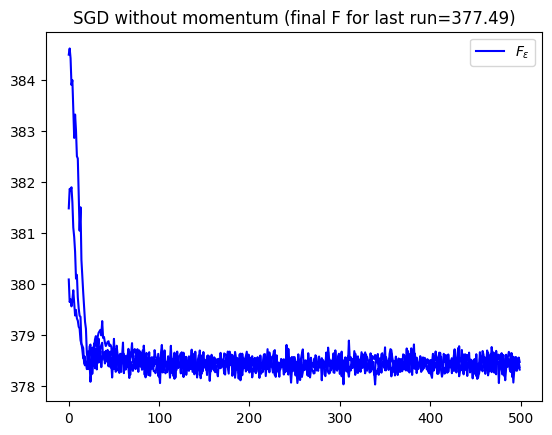

In [2]:
from losses import F_eps, F
from torch.optim import SGD, Adam

n = 100
epsilon = .1
n_samples = 10
d = 3
x, y = draw_samples(n, d)
learning_rate = 0.005
n_iter = 500
n_reps = 3

torch.manual_seed(common_seed)
np.random.seed(common_seed)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d, requires_grad=True)
    optimizer = SGD([theta], lr=0.001, momentum=0.)
    for i in range(n_iter):
        with torch.no_grad():
            theta /= torch.norm(theta)
        loss = F_eps(theta, x, y, 
                     fun=F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"SGD without momentum (final F for last run={float(F(x, y, theta)):.2f})");
print()

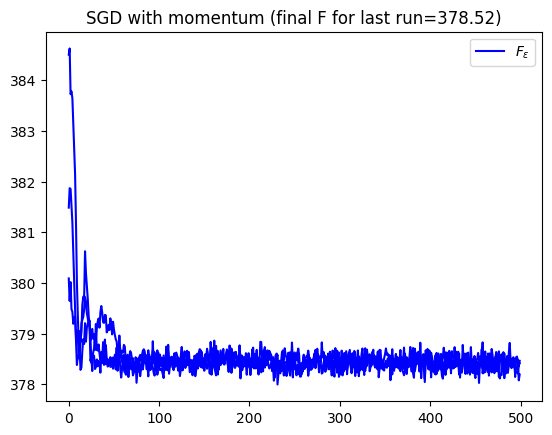

In [3]:
torch.manual_seed(common_seed)
np.random.seed(common_seed)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d, requires_grad=True)
    optimizer = SGD([theta], lr=0.001, momentum=.9)
    for i in range(n_iter):
        with torch.no_grad():
            theta /= torch.norm(theta)
        loss = F_eps(theta, x, y, 
                     fun=F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"SGD with momentum (final F for last run={float(F(x, y, theta)):.2f})");

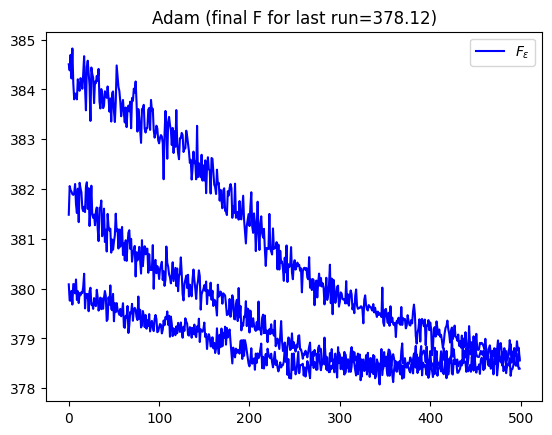

In [4]:
torch.manual_seed(common_seed)
np.random.seed(common_seed)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d, requires_grad=True)
    optimizer = Adam([theta], lr=0.001)
    for i in range(n_iter):
        with torch.no_grad():
            theta /= torch.norm(theta)
        loss = F_eps(theta, x, y, 
                     fun=F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"Adam (final F for last run={float(F(x, y, theta)):.2f})");

## Example of using a different $F$ function (here $W_1$ in place of $W_2^2$)

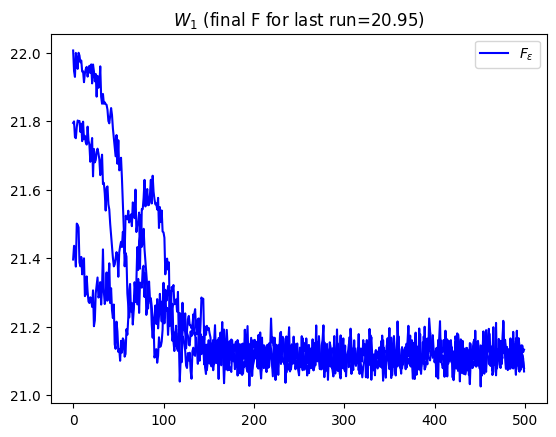

In [5]:
torch.manual_seed(common_seed)
np.random.seed(common_seed)

custom_F = lambda x, y, theta: F(x, y, theta, p=1)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d, requires_grad=True)
    optimizer = SGD([theta], lr=0.001, momentum=0.)
    for i in range(n_iter):
        with torch.no_grad():
            theta /= torch.norm(theta)
        loss = F_eps(theta, x, y, 
                     fun=custom_F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"$W_1$ (final F for last run={float(custom_F(x, y, theta)):.2f})");

## Example using partial optimal transport as the $F$ function

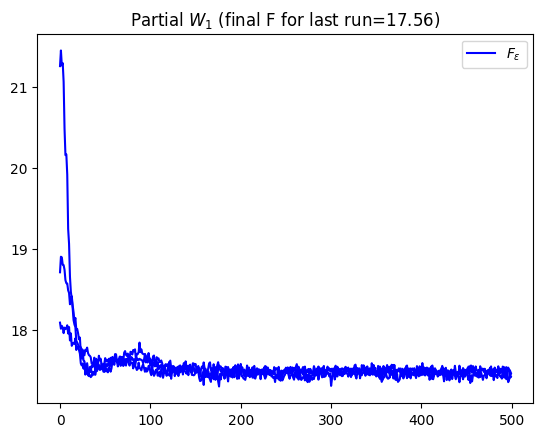

In [6]:
from partial import partial_ot_1d

def F_partial(x, y, theta, max_iter_partial):
    theta_np = theta.detach().numpy()
    x_np = x.detach().numpy()
    y_np = y.detach().numpy()
    proj_x = theta_np @ x_np.T
    proj_y = theta_np @ y_np.T
    ind_x, ind_y, _ = partial_ot_1d(proj_x, proj_y, max_iter=max_iter_partial, p=1)

    sorted_ind_x = np.argsort(proj_x[ind_x])
    sorted_ind_y = np.argsort(proj_y[ind_y])
    subset_x = x_np[ind_x][sorted_ind_x]
    subset_y = y_np[ind_y][sorted_ind_y]
    cost = np.sum(np.abs(subset_x - subset_y))
    return cost / ind_x.shape[0]

torch.manual_seed(common_seed)
np.random.seed(common_seed)

custom_F = lambda x, y, theta: F_partial(x, y, theta, max_iter_partial=n // 2)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d, requires_grad=True)
    optimizer = SGD([theta], lr=0.001, momentum=0.)
    for i in range(n_iter):
        with torch.no_grad():
            theta /= torch.norm(theta)
        loss = F_eps(theta, x, y, 
                     fun=custom_F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"Partial $W_1$ (final F for last run={float(custom_F(x, y, theta)):.2f})");

## Using a neural network for the projection

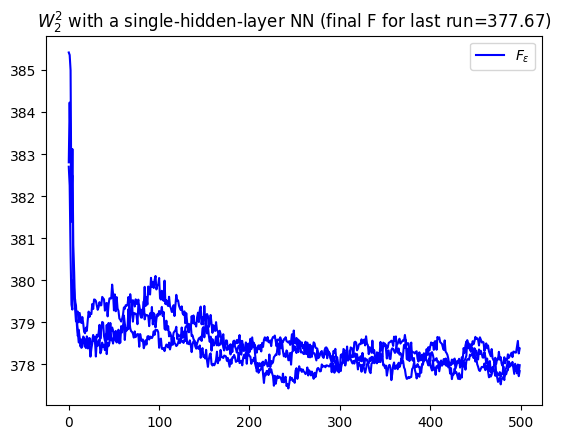

In [7]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

        # Initialisation He pour les poids
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def F_nn(x, y, model, p):
    pos_x_1d = torch.argsort(model(x).flatten())
    pos_y_1d = torch.argsort(model(y).flatten())
    return torch.mean(torch.sum(torch.abs(x[pos_x_1d] - y[pos_y_1d]) ** p, dim=-1), dim=0)

torch.manual_seed(common_seed)
np.random.seed(common_seed)

custom_F = lambda x, y, model: F_nn(x, y, model, p=2)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    model = SimpleNN(input_size=d, hidden_size=256, output_size=1)
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.)
    for i in range(n_iter):
        loss = F_eps(model, x, y, 
                     fun=custom_F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"$W_2^2$ with a single-hidden-layer NN (final F for last run={float(custom_F(x, y, model)):.2f})");

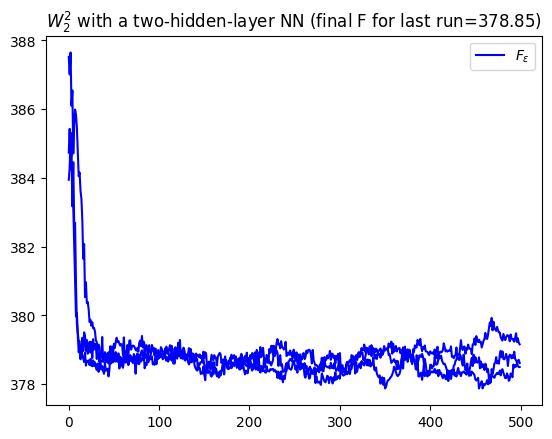

In [8]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

        # Initialisation He pour les poids
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def F_nn(x, y, model, p):
    pos_x_1d = torch.argsort(model(x).flatten())
    pos_y_1d = torch.argsort(model(y).flatten())
    return torch.mean(torch.sum(torch.abs(x[pos_x_1d] - y[pos_y_1d]) ** p, dim=-1), dim=0)

torch.manual_seed(common_seed)
np.random.seed(common_seed)

custom_F = lambda x, y, model: F_nn(x, y, model, p=2)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    model = SimpleNN(input_size=d, hidden_size=256, output_size=1)
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.)
    for i in range(n_iter):
        loss = F_eps(model, x, y, 
                     fun=custom_F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"$W_2^2$ with a two-hidden-layer NN (final F for last run={float(custom_F(x, y, model)):.2f})");

## Projection inspired by Generalized Sliced Wasserstein

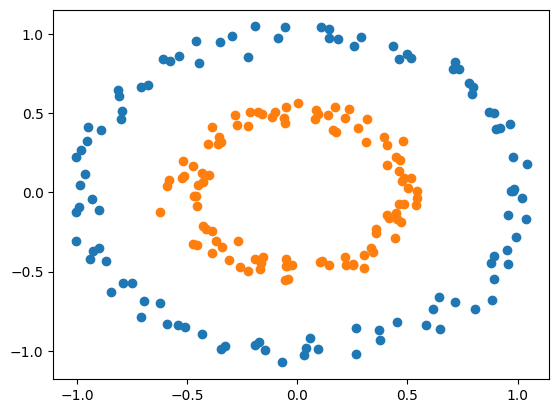

In [9]:
from sklearn.datasets import make_circles

noisy_circles, y = make_circles(n_samples=n*2, factor=0.5, noise=0.05, random_state=170)
x_circ = noisy_circles[np.argwhere(y==0),:].reshape(n, 2)
y_circ = noisy_circles[np.argwhere(y==1),:].reshape(n, 2)

plt.scatter(x_circ[:, 0], x_circ[:, 1])
plt.scatter(y_circ[:, 0], y_circ[:, 1]);

x_circ = torch.tensor(x_circ)
y_circ = torch.tensor(y_circ)

# for i, data in enumerate(x_circ):
#     plt.gca().annotate(f"{float(get_angle(x_circ[i:i+1], torch.tensor([0., 0.]).double())[0]):.2f}", 
#                        (x_circ[i, 0], x_circ[i, 1]))

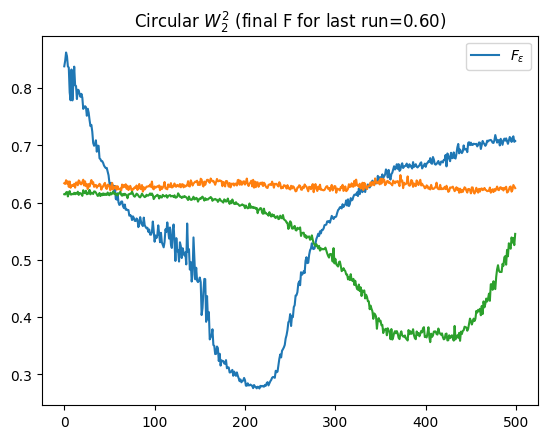

In [10]:
torch.manual_seed(common_seed)
np.random.seed(common_seed)

epsilon = 1e-1
n_samples = 100

def custom_F_circ(x, y, theta):
    p = 2
    pos_x_1d = torch.argsort(torch.atan2((x[:,1] - theta[1]), (x[:,0]-theta[0])))
    pos_y_1d = torch.argsort(torch.atan2((y[:,1] - theta[1]), (y[:,0]-theta[0])))
    return torch.mean(torch.sum(torch.abs(x[pos_x_1d] - y[pos_y_1d]) ** p, dim=-1), dim=0)

d_circ = 2

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d_circ, requires_grad=True)
    with torch.no_grad():
        theta /= torch.norm(theta)
    optimizer = SGD([theta], lr=0.0001)
    for i in range(n_iter):
        loss = F_eps(theta, x_circ, y_circ, 
                     fun=custom_F_circ, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l)  #, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"Circular $W_2^2$ (final F for last run={float(custom_F_circ(x_circ, y_circ, theta)):.2f})");

Text(0.5, 1.0, 'Heatmap de la fonction')

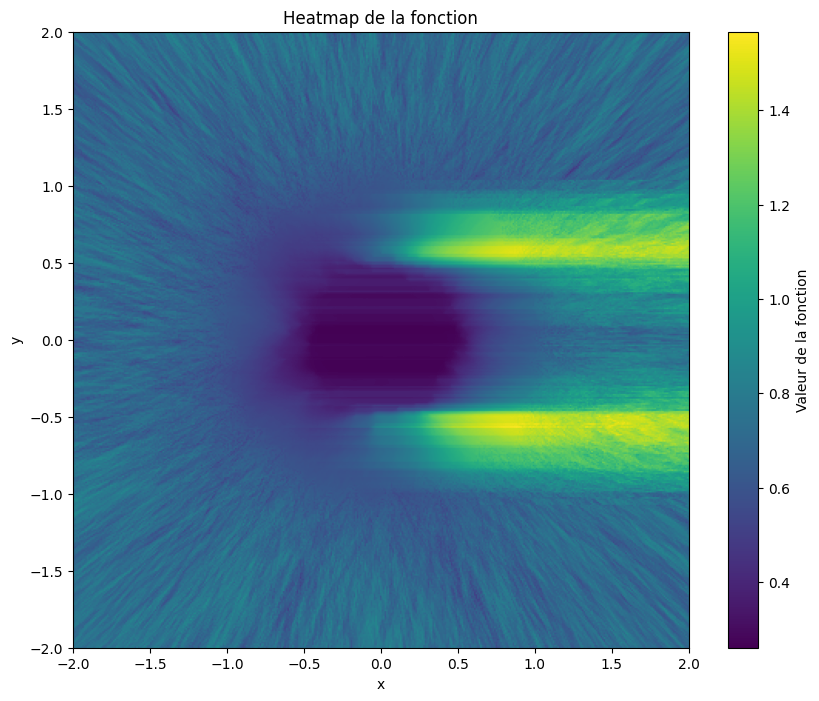

In [11]:
xx = np.linspace(-2, 2, 400)
yy = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(xx, yy)

# Convertir la grille en tenseur torch
thetas = torch.tensor(np.stack([X, Y], axis=-1), dtype=torch.float32)

# Évaluer la fonction sur la grille
Z = np.zeros((400, 400))
for i in range(400):
    for j in range(400):
        Z[i,j] = custom_F_circ(x_circ, y_circ, thetas[i, j])

# Afficher la heatmap
plt.figure(figsize=(10, 8))
plt.imshow(Z, extent=(-2, 2, -2, 2), origin='lower', cmap='viridis')
plt.colorbar(label='Valeur de la fonction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap de la fonction')

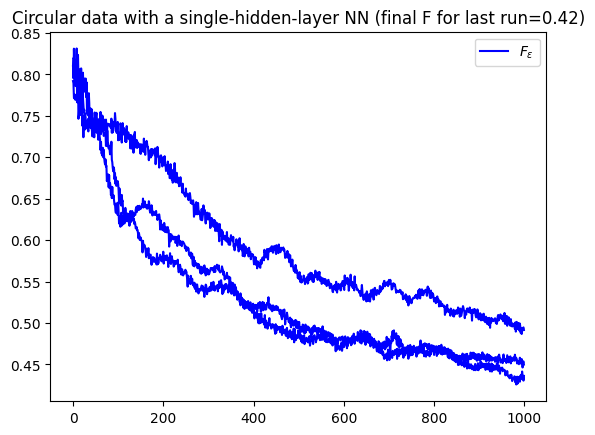

In [12]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

        # Initialisation He pour les poids
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def F_nn(x, y, model, p):
    pos_x_1d = torch.argsort(model(x).flatten())
    pos_y_1d = torch.argsort(model(y).flatten())
    return torch.mean(torch.sum(torch.abs(x[pos_x_1d] - y[pos_y_1d]) ** p, dim=-1), dim=0)

torch.manual_seed(common_seed)
np.random.seed(common_seed)

custom_F = lambda x, y, model: F_nn(x, y, model, p=2)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    model = SimpleNN(input_size=d_circ, hidden_size=256, output_size=1)
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.)
    for i in range(2 * n_iter):
        loss = F_eps(model, x_circ.float(), y_circ.float(), 
                     fun=custom_F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"Circular data with a single-hidden-layer NN (final F for last run={float(custom_F(x_circ.float(), y_circ.float(), model)):.2f})");

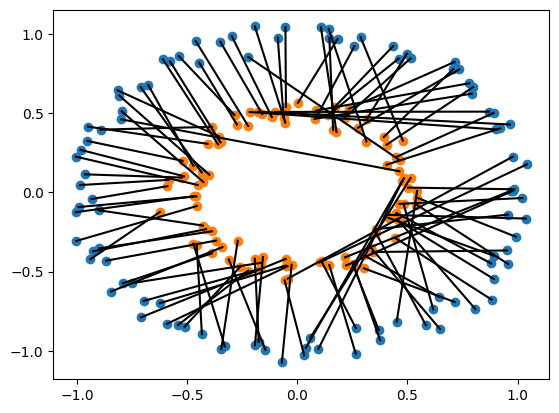

In [13]:
def F_nn_indexes(x, y, model):
    pos_x_1d = torch.argsort(model(x).flatten())
    pos_y_1d = torch.argsort(model(y).flatten())
    return pos_x_1d, pos_y_1d

ind_x, ind_y = F_nn_indexes(x_circ.float(), y_circ.float(), model)

plt.scatter(x_circ.detach().numpy()[:, 0], x_circ.detach().numpy()[:, 1])
plt.scatter(y_circ.detach().numpy()[:, 0], y_circ.detach().numpy()[:, 1]);
for i, j in zip(ind_x, ind_y):
    plt.plot([x_circ.detach().numpy()[i, 0], y_circ.detach().numpy()[j, 0]], 
             [x_circ.detach().numpy()[i, 1], y_circ.detach().numpy()[j, 1]], 
             color='k')


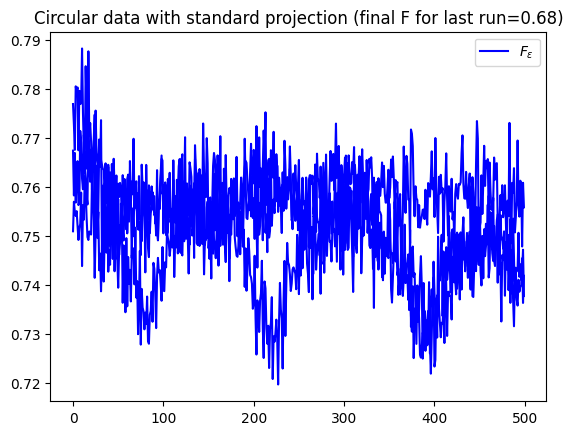

In [14]:
torch.manual_seed(common_seed)
np.random.seed(common_seed)

losses = {}
for id_rep in range(n_reps):
    losses[id_rep] = []
    theta = torch.randn(d_circ, requires_grad=True)
    optimizer = SGD([theta], lr=0.001, momentum=0.)
    for i in range(n_iter):
        with torch.no_grad():
            theta /= torch.norm(theta)
        loss = F_eps(theta, x_circ.float(), y_circ.float(), 
                     fun=F, n_samples=n_samples, epsilon=epsilon)
        loss.backward()
        losses[id_rep].append(loss.item())
        optimizer.step()

for l in losses.values():
    plt.plot(l, color='b')
plt.legend(["$F_{\\varepsilon}$"])
plt.title(f"Circular data with standard projection (final F for last run={float(F(x_circ.float(), y_circ.float(), theta)):.2f})");
print()

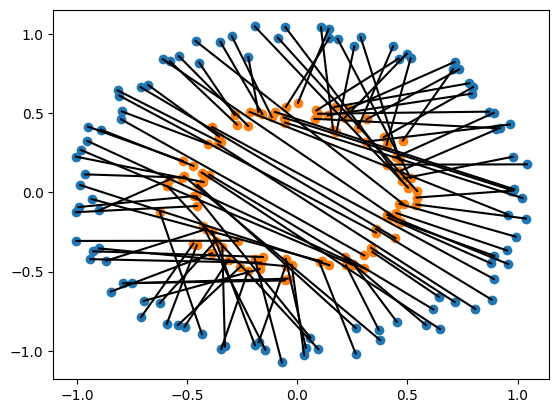

In [16]:
def F_nn_indexes(x, y, theta):
    pos_x_1d = torch.argsort(theta @ x.T)
    pos_y_1d = torch.argsort(theta @ y.T)
    return pos_x_1d, pos_y_1d

ind_x, ind_y = F_nn_indexes(x_circ.float(), y_circ.float(), theta)

plt.scatter(x_circ.detach().numpy()[:, 0], x_circ.detach().numpy()[:, 1])
plt.scatter(y_circ.detach().numpy()[:, 0], y_circ.detach().numpy()[:, 1]);
for i, j in zip(ind_x, ind_y):
    plt.plot([x_circ.detach().numpy()[i, 0], y_circ.detach().numpy()[j, 0]], 
             [x_circ.detach().numpy()[i, 1], y_circ.detach().numpy()[j, 1]], 
             color='k')